# Make ROI from GLM


In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

#from bids import BIDSLayout
import numpy as np
from nilearn import datasets, image, plotting, surface, maskers, masking
from nilearn.image import get_data
import nibabel as nib
import pandas as pd
import scipy.io as spio
from nilearn.masking import apply_mask
import scipy
import copy
import gzip
import shutil
import pickle
from distinctipy import distinctipy
#import siibra
from scipy.ndimage import binary_dilation,binary_closing
import re
#from atlasreader import create_output
#for inline visualization in jupyter notebook
%matplotlib inline

In [2]:
#os.chdir('/mnt/Data1/linjdata1/vswmda/')
os.chdir('/gpfs/scratch/linjjiang/')

In [3]:
os.getcwd()

'/gpfs/scratch/linjjiang'

In [4]:
# initialize a plotting function
def plot_roi_with_atlas(anat,cut_coords,func,atlas,display_mode):
    fig = plt.figure(figsize=(20,3), facecolor="k")
    display = plotting.plot_anat(
        anat, display_mode=display_mode, cut_coords=cut_coords, figure=fig
    )
    display.add_overlay(
        func,cmap='binary'
    ) #cbar_vmin=0,cbar_vmax=1,,colorbar=True
    display.add_contours(
        atlas,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors='red',
    )
    return fig

In [23]:
# load template t1w image 
tpl_t1w = nib.load('atlases/MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_T1w.nii')

# For topN - both hemispheres

In [10]:
top_n_voxels = [{
    'v1': 1000,
    'v2': 1000,
    'ips': 2000,
    'area4': 400,
    'fef': 600,
    'sfg': 1000,
    'mfg': 1000,
    'ifg': 1000,
    'ips0': 300,
    'ips1': 300,
    'ips2': 300,
    'ips3': 300,
    'ips4': 300,
    'ips5': 300,
    'spl1': 300
}]

In [13]:
# Create a pandas DataFrame from the results list
with open(os.path.join('atlases','final_atlas_roi','rsa_mgs1_conj_mgs2_topN',
                       'nperc_by_vox_custom.pkg'),'rb') as f:
    df = pickle.load(f)

In [14]:
print(df)

       ROI  perc subj  nvox  top_nvox  nvox_closed  perc_closed  \
0       v1  54.0  f09  1000      1000         1118         60.0   
1       v2  89.0  f09  1000      1000         1113        100.0   
2      ips  60.0  f09  2000      2000         2310         69.0   
3    area4  51.0  f09   400       400          423         54.0   
4      fef  61.0  f09   600       600          674         69.0   
..     ...   ...  ...   ...       ...          ...          ...   
130   ips2  45.0  f19   300       300          344         52.0   
131   ips3  69.0  f19   300       300          338         78.0   
132   ips4  82.0  f19   300       300          351         96.0   
133   ips5  87.0  f19   300       300          345        101.0   
134   spl1  60.0  f19   300       300          335         67.0   

                                                   img  \
0    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...   
1    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...   
2    <class 'nibabel.

# Plot the masks

In [26]:
from nilearn.plotting import plot_stat_map
# roi_coords = {'v1':list(range(-15,25,5)),
#               'v2':list(range(-15,25,5)),
#               'area4':list(range(52,82,5)),
#                'fef':list(range(0,65,9)),
#                'sfg':list(range(0,65,9)),
#                'mfg':list(range(0,65,9)),
#                'ifg':list(range(0,65,9)),
#                'ips':list(range(20,65,6)),
# }
#                'ips0':list(range(20,65,5)),
#                'ips1':list(range(20,65,5)),
#                'ips2':list(range(20,65,5)),
#                'ips3':list(range(20,65,5)),
#                'ips4':list(range(20,65,5)),
#                'ips5':list(range(20,65,5)),
#                'spl1':list(range(20,65,5))

roi_coords = {'v1':[-5,0,5],
              'v2':[-10,0,10],
              'area4':[50,57,64],
               'fef':[46,54,62],
               'sfg':[54,60,66],
               'mfg':[18,27,36],
               'ifg':[0,8,16],
               'ips':[38,50,62],
}
roi_name = {'v1':'V1',
              'v2':'V2',
              'area4':'M1',
               'fef':'FEF',
               'sfg':'SFG',
               'mfg':'MFG',
               'ifg':'IFG',
               'ips':'IPS'
}

In [27]:
def list_matching_files(directory,pattern):
    # Define the regular expression pattern
    pattern = re.compile(pattern)
    
    # List all files in the directory
    all_files = os.listdir(directory)
    
    # Filter files that match the pattern
    matching_files = [os.path.join(directory, f) for f in all_files if pattern.match(f)]
    
    # Sort the files by name
    matching_files = sorted(matching_files)
    
    return matching_files

In [28]:
# roi = 'v1'
# subject = 'f10'
# roi_path = os.path.join('atlases',
#                                'final_atlas_roi',
#                                 'rsa_mgs1_conj_mgs2_topN')
# roi_file_path = list_matching_files(roi_path,rf'^mgs_dil_custom_.*{roi}_{subject}\.nii$')
# print(roi_file_path)
# img = nib.load(roi_file_path[0]) 
# print(img)

f10 v1 1139


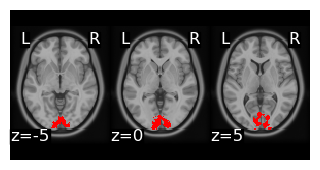

f10 v2 1087


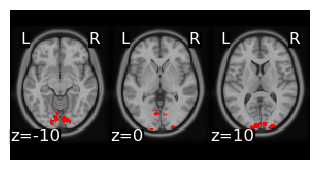

f10 area4 334


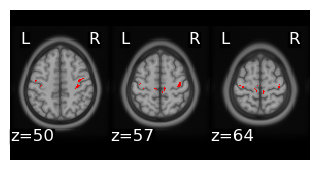

f10 fef 681


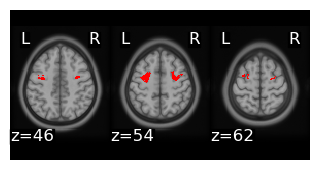

f10 sfg 1120


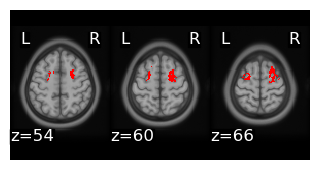

f10 mfg 1181


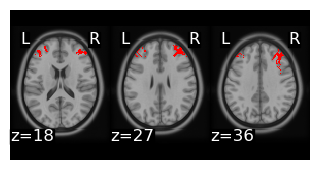

f10 ifg 1153


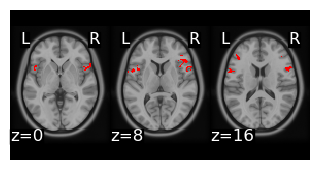

f10 ips 2286


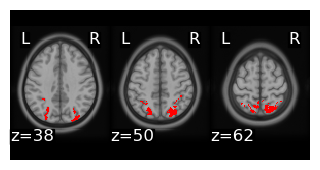

In [30]:
for subject in ['f10']:#subjects:    
    for roi, coords in roi_coords.items():
#     roi = 'v2'
#     coords = roi_coords[roi]
    
        roi_path = os.path.join('atlases',
                                       'final_atlas_roi',
                                        'rsa_mgs1_conj_mgs2_topN')
        roi_file_path = list_matching_files(roi_path,rf'^mgs_dil_custom_.*{roi}_{subject}\.nii$')
        img = nib.load(roi_file_path[0]) 

        print(subject,roi,str(img.get_fdata().sum().astype(int)))

        fig = plt.figure(figsize=(3,1.5))  # Adjust size as needed  #8,1.5
        plotting.plot_stat_map(
                img, bg_img=tpl_t1w,threshold=0, 
                display_mode="z", 
                cut_coords=coords, 
                colorbar=False,
            annotate = True,
                cmap = 'bwr',
            figure = fig)#,
           # title=roi_name[roi]+': '+str(img.get_fdata().sum().astype(int))+' voxels') 
        #roi+','+subject+','+str(img.get_fdata().sum().astype(int))+' voxels; dilated'

        fig.savefig(os.path.join('atlases',
                               'final_atlas_roi',
                                'rsa_mgs1_conj_mgs2_topN',
                                 'figure_'+roi+'_'+subject+'.png'),dpi=300)
        plt.show()
        #display.close()

# For topN - one hemisphere

In [13]:
def list_matching_files(directory,pattern):
    # Define the regular expression pattern
    pattern = re.compile(pattern)
    
    # List all files in the directory
    all_files = os.listdir(directory)
    
    # Filter files that match the pattern
    matching_files = [os.path.join(directory, f) for f in all_files if pattern.match(f)]
    
    # Sort the files by name
    matching_files = sorted(matching_files)
    
    return matching_files

In [12]:
from nilearn.plotting import plot_stat_map
roi_coords = {'l-v1':list(range(-15,25,5)),
              'l-v2':list(range(-15,25,5)),
              'l-area4':list(range(52,82,5)),
               'l-fef':list(range(0,65,9)),
               'l-sfg':list(range(0,65,9)),
               'l-mfg':list(range(0,65,9)),
               'l-ifg':list(range(0,65,9)),
               'l-ips':list(range(20,65,6)),
}
#                'ips0':list(range(20,65,5)),
#                'ips1':list(range(20,65,5)),
#                'ips2':list(range(20,65,5)),
#                'ips3':list(range(20,65,5)),
#                'ips4':list(range(20,65,5)),
#                'ips5':list(range(20,65,5)),
#                'spl1':list(range(20,65,5))

roi_name = {'l-v1':'l-V1',
              'l-v2':'l-V2',
              'l-area4':'l-M1',
               'l-fef':'l-FEF',
               'l-sfg':'l-SFG',
               'l-mfg':'l-MFG',
               'l-ifg':'l-IFG',
               'l-ips':'l-IPS'
}

f10 l-v1 556


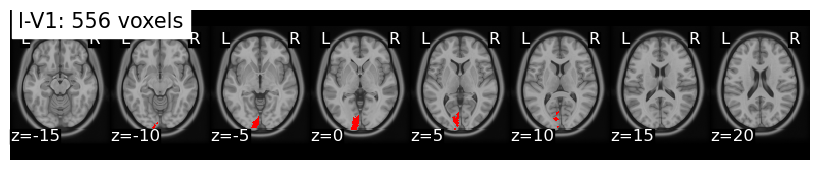

f10 l-v2 549


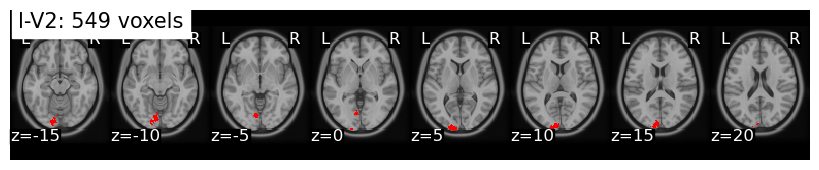

f10 l-area4 149


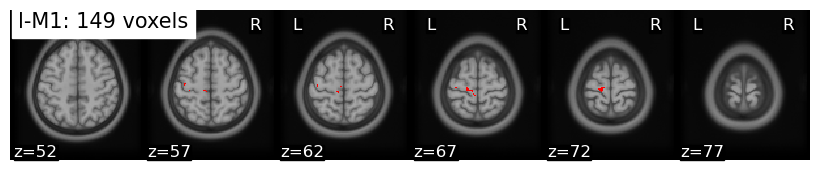

f10 l-fef 321


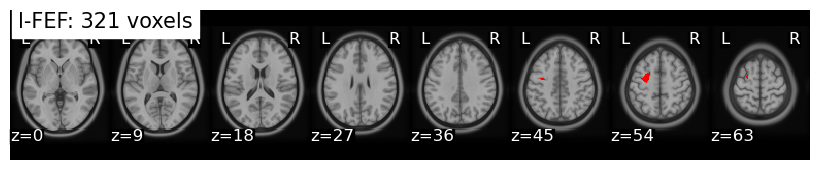

f10 l-sfg 559


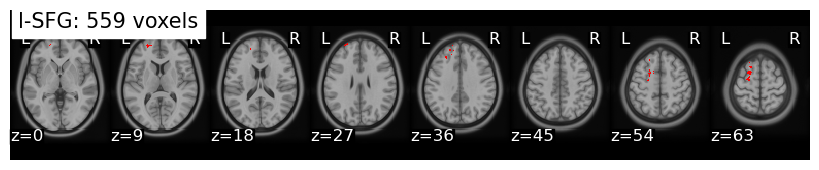

f10 l-mfg 577


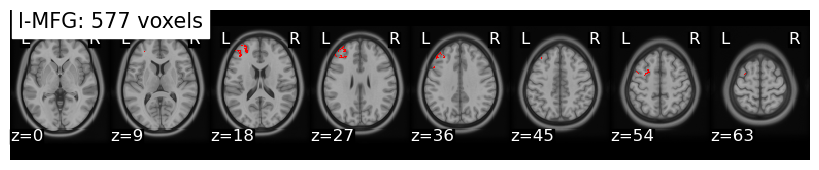

f10 l-ifg 578


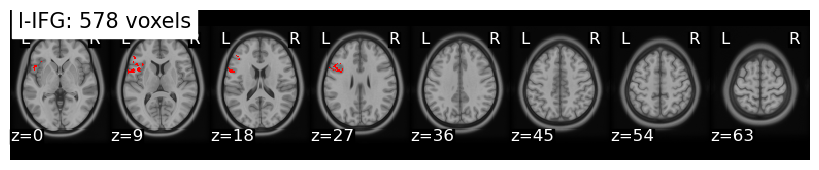

f10 l-ips 1120


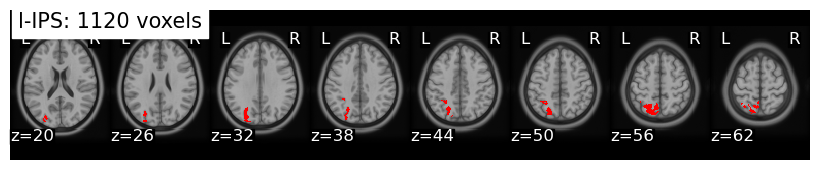

In [14]:
for subject in ['f10']:#subjects:    
    for roi, coords in roi_coords.items():
#     roi = 'v2'
#     coords = roi_coords[roi]
    
        roi_path = os.path.join('atlases',
                                       'final_atlas_roi',
                                        'rsa_mgs1_conj_mgs2_topN_left')
        roi_file_path = list_matching_files(roi_path,rf'^mgs_dil_custom_.*{roi}_{subject}\.nii$')
        img = nib.load(roi_file_path[0]) 

        print(subject,roi,str(img.get_fdata().sum().astype(int)))

        fig = plt.figure(figsize=(8,1.5))  # Adjust size as needed
        plotting.plot_stat_map(
                img, bg_img=tpl_t1w,threshold=0, 
                display_mode="z", 
                cut_coords=coords, 
                colorbar=False,
            annotate = True,
                cmap = 'bwr',
            figure = fig,
            title=roi_name[roi]+': '+str(img.get_fdata().sum().astype(int))+' voxels') 
        #roi+','+subject+','+str(img.get_fdata().sum().astype(int))+' voxels; dilated'

        fig.savefig(os.path.join('atlases',
                               'final_atlas_roi',
                                'rsa_mgs1_conj_mgs2_topN_left',
                                 'mgs_dil_custom_'+roi+'_'+subject+'.png'))
        plt.show()
        #display.close()

In [16]:
from nilearn.plotting import plot_stat_map
roi_coords = {'r-v1':list(range(-15,25,5)),
              'r-v2':list(range(-15,25,5)),
              'r-area4':list(range(52,82,5)),
               'r-fef':list(range(0,65,9)),
               'r-sfg':list(range(0,65,9)),
               'r-mfg':list(range(0,65,9)),
               'r-ifg':list(range(0,65,9)),
               'r-ips':list(range(20,65,6)),
}
#                'ips0':list(range(20,65,5)),
#                'ips1':list(range(20,65,5)),
#                'ips2':list(range(20,65,5)),
#                'ips3':list(range(20,65,5)),
#                'ips4':list(range(20,65,5)),
#                'ips5':list(range(20,65,5)),
#                'spl1':list(range(20,65,5))

roi_name = {'r-v1':'r-V1',
              'r-v2':'r-V2',
              'r-area4':'r-M1',
               'r-fef':'r-FEF',
               'r-sfg':'r-SFG',
               'r-mfg':'r-MFG',
               'r-ifg':'r-IFG',
               'r-ips':'r-IPS'
}

f10 r-v1 551


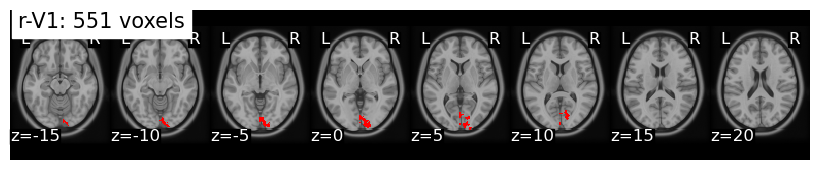

f10 r-v2 522


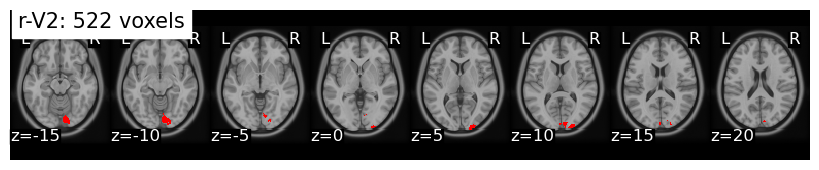

f10 r-area4 175


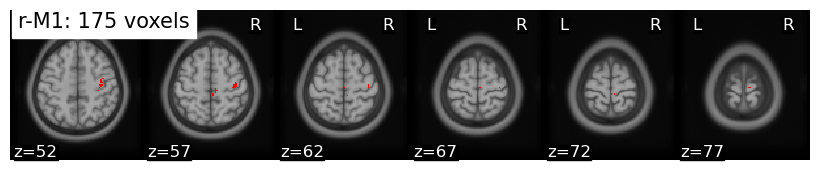

f10 r-fef 331


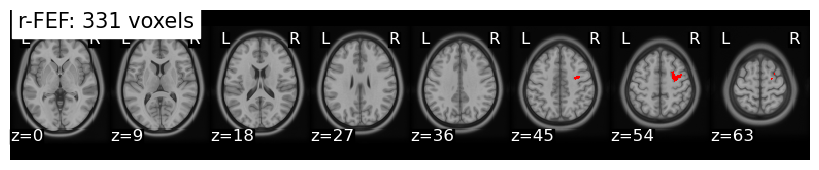

f10 r-sfg 601


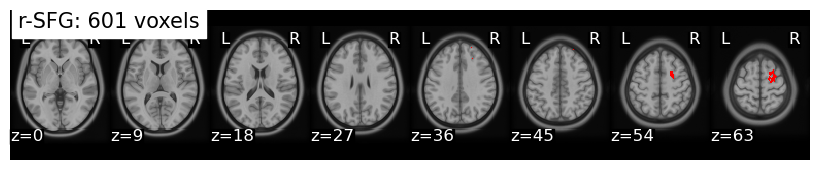

f10 r-mfg 600


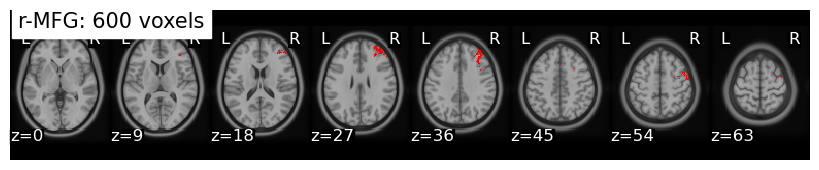

f10 r-ifg 581


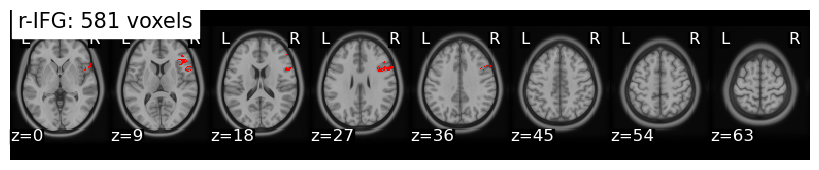

f10 r-ips 1139


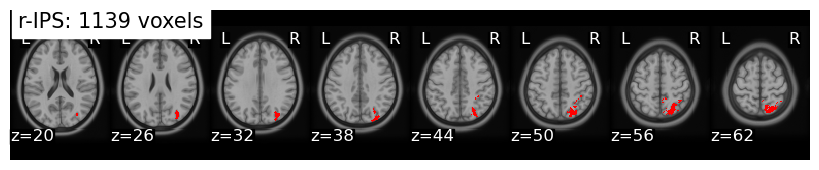

In [17]:
for subject in ['f10']:#subjects:    
    for roi, coords in roi_coords.items():
#     roi = 'v2'
#     coords = roi_coords[roi]
    
        roi_path = os.path.join('atlases',
                                       'final_atlas_roi',
                                        'rsa_mgs1_conj_mgs2_topN_right')
        roi_file_path = list_matching_files(roi_path,rf'^mgs_dil_custom_.*{roi}_{subject}\.nii$')
        img = nib.load(roi_file_path[0]) 

        print(subject,roi,str(img.get_fdata().sum().astype(int)))

        fig = plt.figure(figsize=(8,1.5))  # Adjust size as needed
        plotting.plot_stat_map(
                img, bg_img=tpl_t1w,threshold=0, 
                display_mode="z", 
                cut_coords=coords, 
                colorbar=False,
            annotate = True,
                cmap = 'bwr',
            figure = fig,
            title=roi_name[roi]+': '+str(img.get_fdata().sum().astype(int))+' voxels') 
        #roi+','+subject+','+str(img.get_fdata().sum().astype(int))+' voxels; dilated'

        fig.savefig(os.path.join('atlases',
                               'final_atlas_roi',
                                'rsa_mgs1_conj_mgs2_topN_right',
                                 'mgs_dil_custom_'+roi+'_'+subject+'.png'))
        plt.show()
        #display.close()

# Plot left and right ROI in one brain

In [109]:
from nilearn.plotting import plot_stat_map
roi_coords = {'v1':list(range(-15,25,5)),
              'v2':list(range(-15,25,5)),
              'area4':list(range(52,82,5)),
               'fef':list(range(0,65,9)),
               'sfg':list(range(0,65,9)),
               'mfg':list(range(0,65,9)),
               'ifg':list(range(0,65,9)),
               'ips':list(range(20,65,6)),
}
#                'ips0':list(range(20,65,5)),
#                'ips1':list(range(20,65,5)),
#                'ips2':list(range(20,65,5)),
#                'ips3':list(range(20,65,5)),
#                'ips4':list(range(20,65,5)),
#                'ips5':list(range(20,65,5)),
#                'spl1':list(range(20,65,5))

roi_name = {'v1':'V1',
              'v2':'V2',
              'area4':'M1',
               'fef':'FEF',
               'sfg':'SFG',
               'mfg':'MFG',
               'ifg':'IFG',
               'ips':'IPS'
}

f10 v1 2426


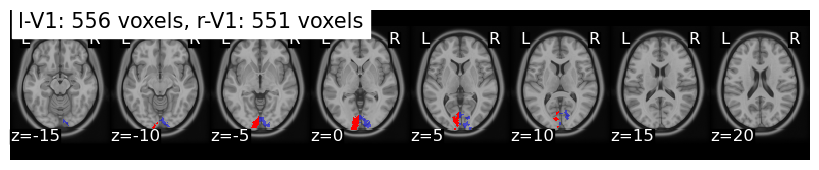

f10 v2 2426


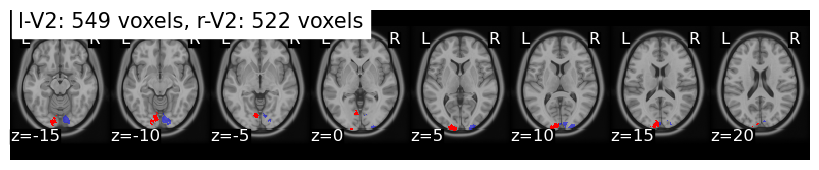

f10 area4 2426


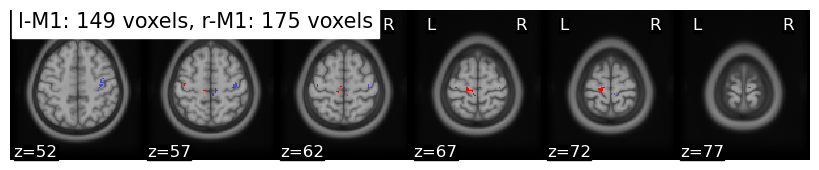

f10 fef 2426


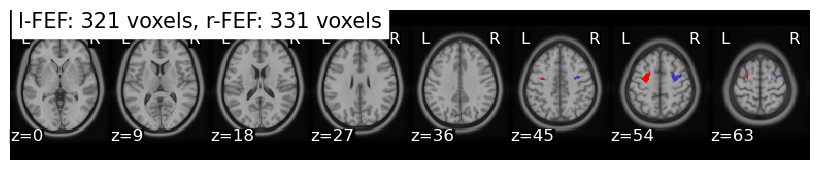

f10 sfg 2426


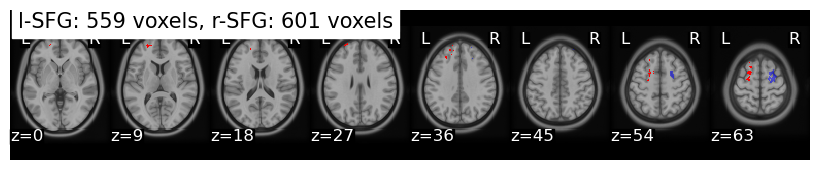

f10 mfg 2426


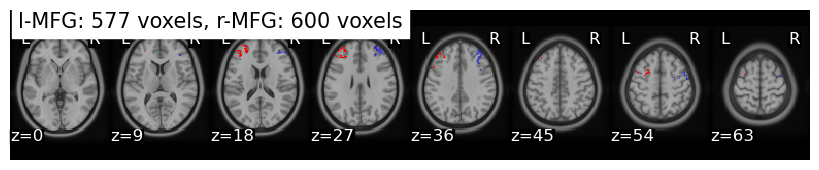

f10 ifg 2426


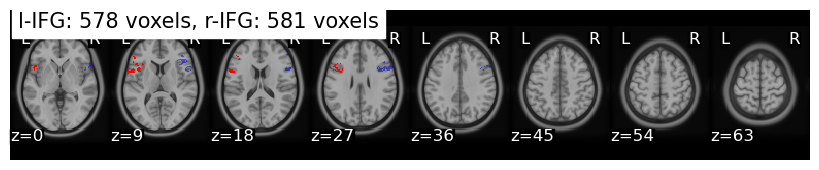

f10 ips 2426


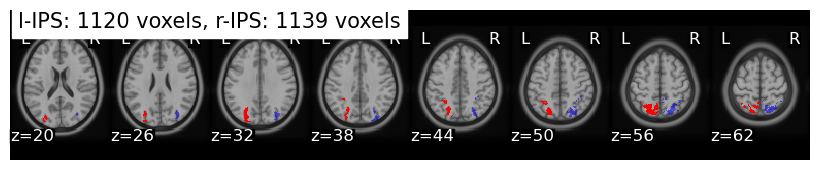

In [129]:
for subject in ['f10']:#subjects:    
    for roi, coords in roi_coords.items():
#     roi = 'v2'
#     coords = roi_coords[roi]
    
        roi_path1 = os.path.join('atlases',
                                       'final_atlas_roi',
                                        'rsa_mgs1_conj_mgs2_topN_left')
        roi_file_path1 = list_matching_files(roi_path1,rf'^mgs_dil_custom_.*{roi}_{subject}\.nii$')
        img1 = nib.load(roi_file_path1[0]) 

        
        roi_path2 = os.path.join('atlases',
                                       'final_atlas_roi',
                                        'rsa_mgs1_conj_mgs2_topN_right')
        roi_file_path2 = list_matching_files(roi_path2,rf'^mgs_dil_custom_.*{roi}_{subject}\.nii$')
        img2 = nib.load(roi_file_path2[0]) 
        
        print(subject,roi,str(img.get_fdata().sum().astype(int)))

        vox_num1 = img1.get_fdata().sum().astype(int)
        vox_num2 = img2.get_fdata().sum().astype(int)
        
        fig = plt.figure(figsize=(8,1.5))  # Adjust size as needed
        display = plotting.plot_stat_map(
                img1, bg_img=tpl_t1w,threshold=0, 
                display_mode="z", 
                cut_coords=coords, 
                colorbar=False,
            annotate = True,
                cmap = plotting.cm.red_transparent,
            figure = fig,
        title = 'l-'+roi_name[roi]+': '+str(vox_num1)+' voxels, r-'+roi_name[roi]+': '+str(vox_num2)+' voxels') 
        
        
        display.add_overlay(
                img2, threshold=0, 
#                 display_mode="z", 
#                 cut_coords=coords, 
#                 colorbar=False,
#             annotate = True,
                cmap = plotting.cm.blue_transparent)
#             figure = fig,
#             title=roi_name[roi]+': '+str(img1.get_fdata().sum().astype(int))+' voxels') 
            
        #roi+','+subject+','+str(img.get_fdata().sum().astype(int))+' voxels; dilated'


        #title = f"l-{roi_name[roi]} : {vox_num1} voxels, r-{roi_name[roi]}: {vox_num2} voxels"
    
        #plt.title(title)
        #plt.suptitle(title, x=0, y=1, ha='left')
        plt.show()
        #display.close()

# For thresholded mgs ROIs

In [19]:
from nilearn.plotting import plot_stat_map
roi_coords = {'v1':list(range(-15,25,5)),
              'v2':list(range(-15,25,5)),
              'area4':list(range(52,82,5)),
               'fef':list(range(0,65,9)),
               'sfg':list(range(0,65,9)),
               'mfg':list(range(0,65,9)),
               'ifg':list(range(0,65,9)),
               'ips':list(range(20,65,6)),
}
#                'ips0':list(range(20,65,5)),
#                'ips1':list(range(20,65,5)),
#                'ips2':list(range(20,65,5)),
#                'ips3':list(range(20,65,5)),
#                'ips4':list(range(20,65,5)),
#                'ips5':list(range(20,65,5)),
#                'spl1':list(range(20,65,5))

roi_name = {'v1':'V1',
              'v2':'V2',
              'area4':'M1',
               'fef':'FEF',
               'sfg':'SFG',
               'mfg':'MFG',
               'ifg':'IFG',
               'ips':'IPS'
}

f10 v1 604


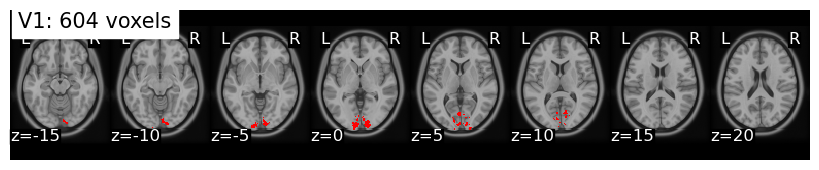

f10 v2 423


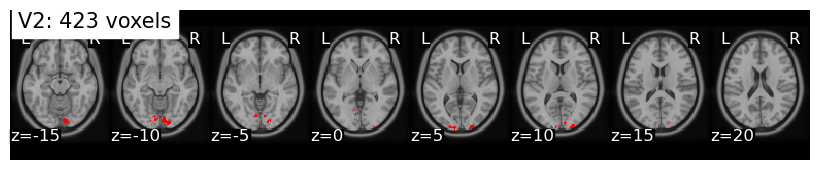

f10 area4 34


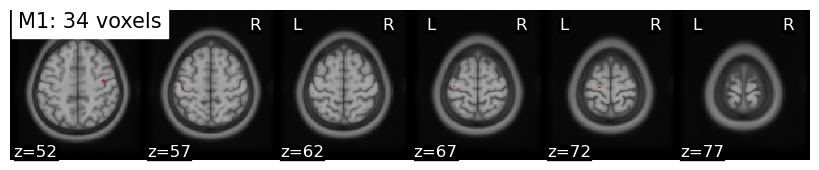

f10 fef 538


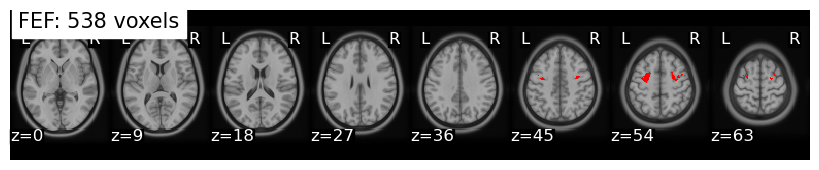

f10 sfg 1239


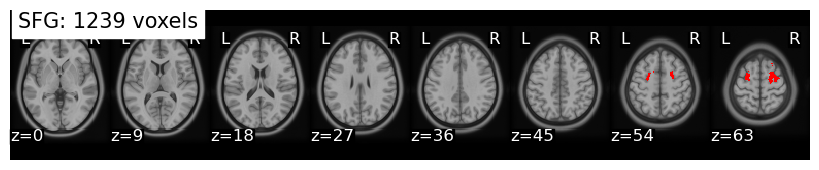

f10 mfg 1332


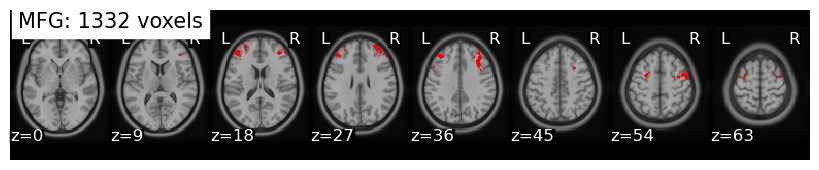

f10 ifg 1644


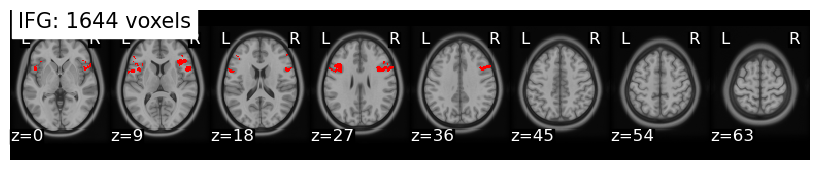

f10 ips 2426


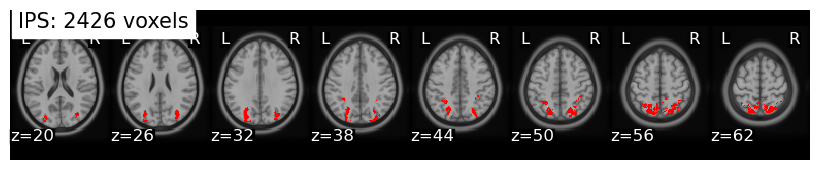

In [21]:
for subject in ['f10']:#subjects:    
    for roi, coords in roi_coords.items():
#     roi = 'v2'
#     coords = roi_coords[roi]
    
        roi_path = os.path.join('atlases',
                                       'final_atlas_roi',
                                        'rsa_mgs1_conj_mgs2_0.05_50')
        roi_file_path = list_matching_files(roi_path,rf'^mgs_(?!close).*{roi}_{subject}\.nii$')
        img = nib.load(roi_file_path[0]) 

        print(subject,roi,str(img.get_fdata().sum().astype(int)))

        fig = plt.figure(figsize=(8,1.5))  # Adjust size as needed
        plotting.plot_stat_map(
                img, bg_img=tpl_t1w,threshold=0, 
                display_mode="z", 
                cut_coords=coords, 
                colorbar=False,
            annotate = True,
                cmap = 'bwr',
            figure = fig,
            title=roi_name[roi]+': '+str(img.get_fdata().sum().astype(int))+' voxels') 
        #roi+','+subject+','+str(img.get_fdata().sum().astype(int))+' voxels; dilated'

        fig.savefig(os.path.join('atlases',
                               'final_atlas_roi',
                                'rsa_mgs1_conj_mgs2_0.05_50',
                                 'Fig_mgs_'+roi+'_'+subject+'.png'))
        plt.show()
        #display.close()

# Atlas ROIs

In [19]:
from nilearn.plotting import plot_stat_map
roi_coords = {'v1':list(range(-15,25,5)),
              'v2':list(range(-15,25,5)),
              'area4':list(range(52,82,5)),
               'fef':list(range(0,65,9)),
               'sfg':list(range(0,65,9)),
               'mfg':list(range(0,65,9)),
               'ifg':list(range(0,65,9)),
               'ips':list(range(20,65,6)),
}
#                'ips0':list(range(20,65,5)),
#                'ips1':list(range(20,65,5)),
#                'ips2':list(range(20,65,5)),
#                'ips3':list(range(20,65,5)),
#                'ips4':list(range(20,65,5)),
#                'ips5':list(range(20,65,5)),
#                'spl1':list(range(20,65,5))

roi_name = {'v1':'V1',
              'v2':'V2',
              'area4':'M1',
               'fef':'FEF',
               'sfg':'SFG',
               'mfg':'MFG',
               'ifg':'IFG',
               'ips':'IPS'
}

In [56]:
import nilearn
import seaborn as sns

In [88]:
pmfg = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/pmfg-md.nii')
amfg = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/amfg-md.nii')
ifg = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/ifg-md.nii')
spcs = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/spcs-md.nii')
ipcs = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/ipcs-md.nii')
fef = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/fef-wang25.nii')
area4 = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/area4-ju50.nii')

masks = [area4,spcs,ipcs,pmfg,amfg,ifg] #fef,
vox_num = []
for mask in masks:
    vox_num.append(mask.get_fdata().sum().astype(int))

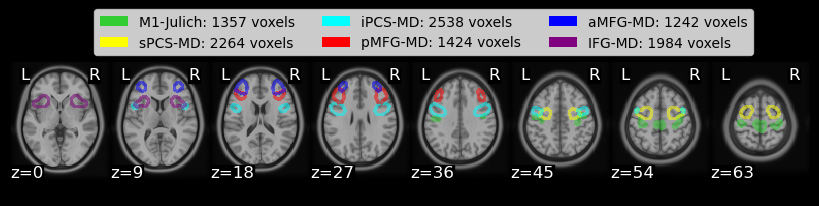

In [89]:

# plot ROI
fig = plt.figure(figsize=(8,1.5), facecolor="k")

display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(0,65,9)), figure=fig 
) #2,65,9
#masks = [mfg_aal, sfg_aal, ifg_aal, fef_wang]
#masks = [img_dil_mfg,img_dil_sfg,img_dil_fef]
colors = ["limegreen","yellow","cyan","red","blue","purple"] # sns.color_palette("colorblind", 5) #

for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc=colors[0])
p2 = Rectangle((0,0), 1, 1, fc=colors[1])
p3 = Rectangle((0,0), 1, 1, fc=colors[2])
p4 = Rectangle((0,0), 1, 1, fc=colors[3])
p5 = Rectangle((0,0), 1, 1, fc=colors[4])
p6 = Rectangle((0,0), 1, 1, fc=colors[5])
plt.legend([p1, p2, p3, p4, p5,p6], 
           ["M1-Julich: "+str(vox_num[0])+" voxels",
               "sPCS-MD: "+str(vox_num[1])+" voxels",
           "iPCS-MD: "+str(vox_num[2])+" voxels",
           "pMFG-MD: "+str(vox_num[3])+" voxels",
           "aMFG-MD: "+str(vox_num[4])+" voxels",
            "IFG-MD: "+str(vox_num[5])+" voxels"],
           ncol=3,bbox_to_anchor=(0.5, 1.5))
#"FEF-Wang: "+str(vox_num[0])+" voxels",
plt.savefig(os.path.join('atlases',
                       'final_atlas_roi',
                        'rsa_atlas_roi',
                         'Fig_MDroi.png'),dpi=300)
plt.show()


In [90]:
ips0_wang = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/ips0-wang15.nii')
ips1_wang = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/ips1-wang15.nii')
ips2_wang = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/ips2-wang15.nii')
spl1_wang = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/spl1-wang15.nii')
ips_wang = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/ips-wang15.nii')

masks = [ips_wang, ips0_wang,ips1_wang,ips2_wang,spl1_wang]#, spl1_wang] ips3_wang,ips4_wang,ips5_wang,
vox_num = []
for mask in masks:
    vox_num.append(mask.get_fdata().sum().astype(int))

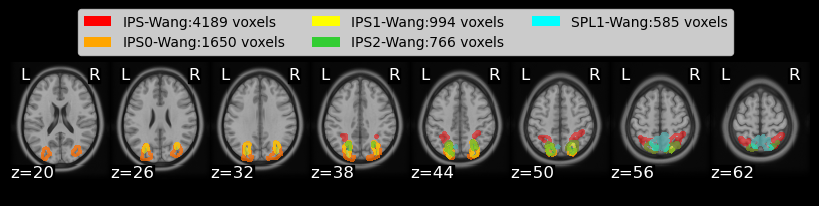

In [97]:
# plot these ROIs onto the brain
    
fig = plt.figure(figsize=(8,1.5), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(20,65,6)), figure=fig
)

colors = ["red","orange","yellow","limegreen","cyan","blue","purple"]#, "limegreen"] #,'orange'
p = []
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4,
        levels=[0],
        colors=[color],
    )
    p.append(Rectangle((0,0), 1, 1, fc=color))

plt.legend([p[0],p[1],p[2],p[3],p[4]],  #,p[5],p[6]
           ["IPS-Wang:"+str(vox_num[0])+" voxels",
            "IPS0-Wang:"+str(vox_num[1])+" voxels",
            "IPS1-Wang:"+str(vox_num[2])+" voxels",
            "IPS2-Wang:"+str(vox_num[3])+" voxels",
            "SPL1-Wang:"+str(vox_num[4])+" voxels"], 
           ncol=3,bbox_to_anchor=(0.3, 1.5)) #, "wang spl" , p3 
#             "ips5:"+str(vox_num[5])+" voxels",
#             "spl1:"+str(vox_num[6])+" voxels"
plt.show()


In [98]:
v1 = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/v1-wang25.nii')
v2 = nib.load('atlases/final_atlas_roi/rsa_atlas_roi/v2-wang25.nii')

masks = [v1, v2]#, spl1_wang] ips3_wang,ips4_wang,ips5_wang,
vox_num = []
for mask in masks:
    vox_num.append(mask.get_fdata().sum().astype(int))

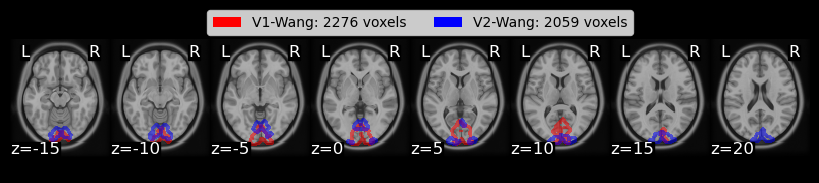

In [108]:
# plot these ROIs onto the brain
fig = plt.figure(figsize=(8,1.5), facecolor="k")
display = plotting.plot_anat(
    tpl_t1w, display_mode="z", cut_coords=list(range(-15,25,5)), figure=fig
)
    
colors = ["red",'blue']
for mask, color in zip(masks, colors):
    display.add_contours(
        mask,
        contours=1,
        antialiased=False,
        alpha=0.5,
        linewidth=4.0,
        levels=[0],
        colors=[color],
    )
p1 = Rectangle((0,0), 1, 1, fc="red")
p2 = Rectangle((0,0), 1, 1, fc="blue")
p3 = Rectangle((0,0), 1, 1, fc="limegreen")
p4 = Rectangle((0,0), 1, 1, fc="orange")
plt.legend([p1, p2], ["V1-Wang: "+str(vox_num[0])+" voxels",
                      "V2-Wang: "+str(vox_num[1])+" voxels"], 
          ncol=2,bbox_to_anchor=(-0.7, 1.3))

plt.show()